## 0) Import Libraries and General Script

In [69]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

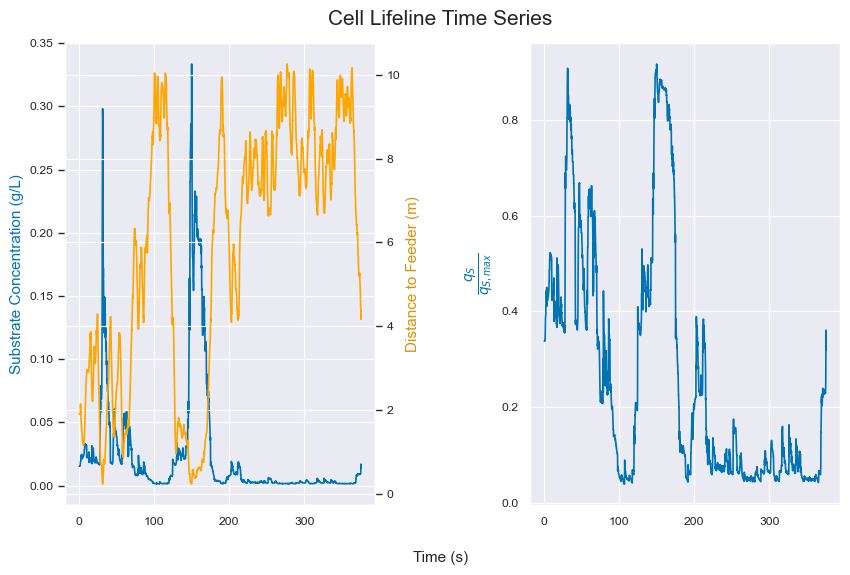

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


## Training on multiple lifelines

In [132]:
import os
import pandas as pd
import numpy as np

folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

expected_timepoints = 376

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    # Select every 10th row and ensure there are exactly 375 timepoints
    reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
    reduced_df.to_csv(file_path, sep="\t")

data_list = []
filtered_reactions = None

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)

    if filtered_reactions is None:
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        filtered_reactions = unique_reactions_fluxes_df.columns

    filtered_lifeline_df = lifeline_df[filtered_reactions]

    if filtered_lifeline_df.shape != (expected_timepoints, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected ({expected_timepoints}, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


C:\Users\elysi\AppData\Local\Temp\ipykernel_23932\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_23932\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expected_timepoints]
C:\Users\elysi\AppData\Local\Temp\ipykernel_23932\4099083542.py:15: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  reduced_df = lifeline_df.iloc[::10][:expecte

Shape of the Big Matrix: (376, 14, 48)


In [199]:
from sklearn.preprocessing import StandardScaler
import numpy as np

n_timesteps, n_samples, n_features = data_3d.shape

# Initialize a scaler for each feature for each sample
scalers = [[StandardScaler() for _ in range(n_features)] for _ in range(n_samples)]

# Scaled data will have the same shape as data_3d
scaled_data = np.empty_like(data_3d, dtype=float)

# Apply the scalers to each feature for each sample across all timesteps
for sample_index in range(n_samples):
    for feature_index in range(n_features):
        # Extract the feature data for the current sample
        feature_data = data_3d[:, sample_index, feature_index].reshape(-1, 1)
        
        # Fit and transform the data using the corresponding scaler
        scaled_feature_data = scalers[sample_index][feature_index].fit_transform(feature_data)
        
        # Assign the scaled data back to its position in the scaled_data array
        scaled_data[:, sample_index, feature_index] = scaled_feature_data.flatten()

# No need to transpose in this case as we're scaling each feature for each lifeline independently

# Transpose scaled_data to have the shape (n_samples, n_timesteps, n_features)
scaled_data = np.transpose(scaled_data, (1, 0, 2))
print("Shape of the Scaled Data:", scaled_data.shape)

Shape of the Scaled Data: (376, 14, 48)


Test without Hyperparameter Tuning

In [185]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=3, shuffle=True):
        # data shape should be (14, 376, 48) before passing into this generator
        self.data = data
        self.batch_size = batch_size  # Intending to treat each lifeline as a batch
        self.shuffle = shuffle
        self.indices = np.arange(data.shape[0])  # Number of lifelines
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute how many batches are in the dataset
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.data))
        
        # Selecting the batch (handling the case where the last batch may be smaller)
        batch_data = self.data[start_idx:end_idx]  # Shape should be (batch_size, 376, 48)
        
        # Ensure batch_data is reshaped correctly if batch_size = 1 to avoid shape mismatch
        if batch_data.shape[0] == 1:
            batch_data = batch_data.reshape(batch_data.shape[1:])  # Reshape to (376, 48)
            batch_data = np.expand_dims(batch_data, axis=0)  # Add batch dimension back
        
        return batch_data, batch_data  # X and Y are the same for autoencoder

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Define the input layer to match the shape of each lifeline sequence
inp = Input(shape=(376, 48))  # 376 timesteps, 48 features

# Encoder
encoder_lstm = LSTM(70, activation='tanh', return_sequences=False)(inp)
encoded = Dense(40, activation='tanh')(encoder_lstm)

# Decoder
repeated_vector = RepeatVector(n_timesteps)(encoded)
decoder_lstm = LSTM(70, activation='tanh', return_sequences=True)(repeated_vector)
#decoder_output = TimeDistributed(Dense(n_features, activation='linear'))(decoder_lstm)  
decoder_output = LSTM(n_features, activation='linear', return_sequences=True)(decoder_lstm)

# Define your learning rate
initial_learning_rate = 0.005

# Create your optimizer with the desired learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Autoencoder model
autoencoder = Model(inputs=inp, outputs=decoder_output)
autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.summary()



Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 376, 48)]         0         
                                                                 
 lstm_51 (LSTM)              (None, 70)                33320     
                                                                 
 dense_45 (Dense)            (None, 40)                2840      
                                                                 
 repeat_vector_24 (RepeatVe  (None, 376, 40)           0         
 ctor)                                                           
                                                                 
 lstm_52 (LSTM)              (None, 376, 70)           31080     
                                                                 
 lstm_53 (LSTM)              (None, 376, 48)           22848     
                                                          

In [189]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# The second dimension, 14, represents the samples (lifelines)
# Split indices of the samples into training and validation sets
train_indices, val_indices = train_test_split(np.arange(scaled_data.shape[0]), test_size=0.2, random_state=42)
# train_indices, val_indices = train_test_split(np.arange(data_3d.shape[0]), test_size=0.2, random_state=42)

# Extract the corresponding data for training and validation
# Keep all timesteps (first dimension) and features (third dimension) intact
train_data = scaled_data[train_indices, :, :]
val_data = scaled_data[val_indices, :, :]

# Now train_data and val_data should have shapes like (376, num_train_samples, 48) and (376, num_val_samples, 48) respectively
print("Train data shape:", train_data.shape)



Train data shape: (11, 376, 48)


In [191]:
# Show first rows of train_gen and val_gen
print("First rows of train_gen and val_gen:")
print(train_gen[0][0])

First rows of train_gen and val_gen:
[[[-3.80743346e-01 -3.80743346e-01 -2.35162667e-01 ... -7.73282009e-01
   -6.23032981e-01 -8.90666408e-01]
  [-2.42456217e-02 -2.42456217e-02  7.21159005e-02 ... -8.14546033e-01
   -2.18894336e-01 -8.90666408e-01]
  [ 9.84132248e-02  9.84132248e-02  1.77840095e-01 ... -8.28743592e-01
   -7.98438549e-02 -8.90666408e-01]
  ...
  [-7.94572429e-01 -7.94572429e-01 -8.72137355e-01 ...  1.34913317e+00
   -6.06351930e-01  1.36992633e+00]
  [-7.88773898e-01 -7.88773898e-01 -8.61431326e-01 ...  1.30621334e+00
   -6.09672352e-01  1.32388809e+00]
  [-7.95290427e-01 -7.95290427e-01 -8.73463019e-01 ...  1.35444768e+00
   -6.05940782e-01  1.37562697e+00]]

 [[-9.56228916e-01 -9.56228916e-01 -9.31466366e-01 ...  3.87619333e-01
   -9.81682446e-01  1.50228275e-01]
  [-9.64732039e-01 -9.64732039e-01 -9.49015004e-01 ...  5.37745092e-01
   -9.77223021e-01  3.29823888e-01]
  [-7.34330830e-01 -7.34330830e-01 -6.82646178e-01 ... -2.26959198e-01
   -8.01050693e-01 -5.222181

In [192]:
# Create the generators with the correct batch size
train_gen = DataGenerator(train_data, batch_size=3, shuffle=True)
val_gen = DataGenerator(val_data, batch_size=3, shuffle=False)  # No need to shuffle validation data

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the autoencoder using the generators
history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[reduce_lr, early_stop])

# Predict on the entire validation set
val_predictions = autoencoder.predict(val_gen)

# Compute mean squared error on the validation set
mean_squared_error = np.mean(np.square(val_data - val_predictions))

# Compute root mean squared error (RMSE)
reconstruction_loss = np.sqrt(mean_squared_error)
print(f"Validation RMSE: {reconstruction_loss}")


Epoch 1/100
4/4 [==============================] - 8s 750ms/step - loss: 1.0054 - val_loss: 1.0052 - lr: 0.0050
Epoch 2/100
4/4 [==============================] - 2s 544ms/step - loss: 1.0002 - val_loss: 0.9997 - lr: 0.0050
Epoch 3/100
4/4 [==============================] - 2s 533ms/step - loss: 1.0006 - val_loss: 0.9994 - lr: 0.0050
Epoch 4/100
4/4 [==============================] - 2s 537ms/step - loss: 0.9983 - val_loss: 0.9961 - lr: 0.0050
Epoch 5/100
4/4 [==============================] - 2s 471ms/step - loss: 0.9973 - val_loss: 0.9955 - lr: 0.0050
Epoch 6/100
4/4 [==============================] - 2s 509ms/step - loss: 0.9968 - val_loss: 0.9941 - lr: 0.0050
Epoch 7/100
4/4 [==============================] - 2s 492ms/step - loss: 0.9964 - val_loss: 0.9939 - lr: 0.0050
Epoch 8/100
4/4 [==============================] - 2s 479ms/step - loss: 0.9963 - val_loss: 0.9938 - lr: 0.0050
Epoch 9/100
4/4 [==============================] - 2s 515ms/step - loss: 0.9962 - val_loss: 0.9937 - lr:

In [58]:
# Assuming 'original_data' is your input data shaped appropriately
latent_representations = encoder_model.predict(original_data)

# latent_representations now contains 14 separate 40-dimensional vectors,
# each corresponding to a lifeline.


1/1 [==============================] - 6s 6s/step


In [59]:
import pandas as pd

# Convert to DataFrame
latent_df = pd.DataFrame(latent_representations)

# Optionally, name your columns for clarity
latent_df.columns = [f"Feature_{i}" for i in range(latent_df.shape[1])]


In [60]:
file_path = "latent_representations_test.xlsx"

# Save to Excel
latent_df.to_excel(file_path, index=False)  # Set index=False if you don't want the row indices in your file


In [194]:
reconstructed_data = autoencoder.predict(scaled_data)

1/1 [==============================] - 0s 228ms/step


In [195]:
reconstructed_data.shape

(14, 376, 48)

In [196]:
reconstructed_data[2, :, 6]

array([-0.00513674, -0.01010602, -0.01456247, -0.01836522, -0.0214977 ,
       -0.02400581, -0.02596244, -0.02744915, -0.02854683, -0.02933079,
       -0.02986817, -0.03021673, -0.03042469, -0.03053109, -0.03056674,
       -0.03055525, -0.03051424, -0.03045649, -0.03039096, -0.03032369,
       -0.03025856, -0.03019788, -0.03014287, -0.03009397, -0.03005118,
       -0.03001417, -0.02998249, -0.02995555, -0.02993281, -0.02991371,
       -0.02989775, -0.02988447, -0.02987344, -0.02986432, -0.0298568 ,
       -0.02985062, -0.02984555, -0.0298414 , -0.02983802, -0.02983526,
       -0.02983302, -0.0298312 , -0.02982973, -0.02982855, -0.02982759,
       -0.02982682, -0.02982622, -0.02982572, -0.02982533, -0.02982502,
       -0.02982477, -0.02982458, -0.02982442, -0.0298243 , -0.02982421,
       -0.02982413, -0.02982407, -0.02982402, -0.02982399, -0.02982396,
       -0.02982394, -0.02982392, -0.02982391, -0.0298239 , -0.02982388,
       -0.02982388, -0.02982388, -0.02982387, -0.02982387, -0.02

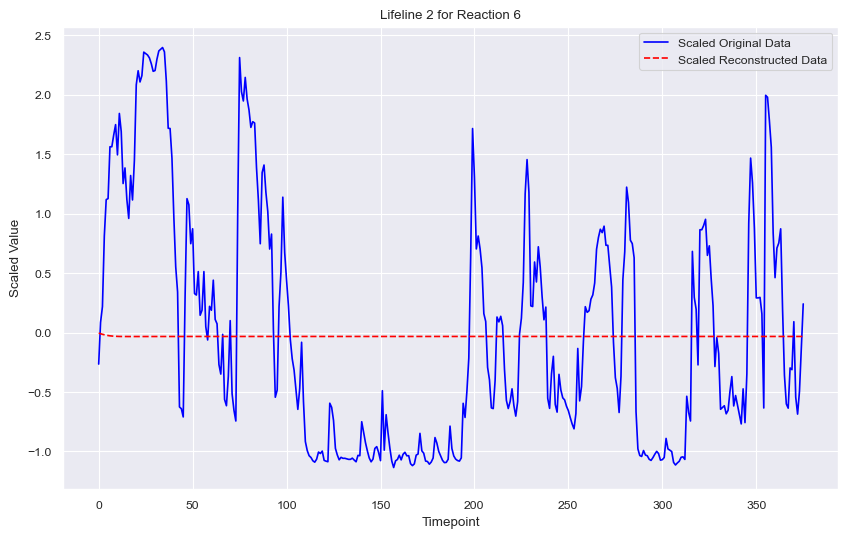

In [197]:
import matplotlib.pyplot as plt

# Choose a specific lifeline and reaction for plotting
lifeline_index = 1  # Index for lifeline 2 (assuming lifelines are zero-indexed)
reaction_index = 6  # Reaction index

# Extract series for plotting
scaled_series = scaled_data[lifeline_index, :, reaction_index]
reconstructed_series = reconstructed_data[lifeline_index, :, reaction_index]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(scaled_series, label='Scaled Original Data', color='blue')
plt.plot(reconstructed_series, label='Scaled Reconstructed Data', color='red', linestyle='--')
plt.title(f'Lifeline {lifeline_index + 1} for Reaction {reaction_index}')
plt.xlabel('Timepoint')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# Multiple Lifelines Testing with Hyperparameter Tuning

In [26]:
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def objective(trial, data):
    # Hyperparameters
    hidden_units = trial.suggest_int('hidden_units', 10, 120)
    latent_units = trial.suggest_int('latent_units', 5, 40)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Model Definition
    inp = Input(shape=(data.shape[1], data.shape[2]))
    encoder = LSTM(hidden_units, activation=activation, return_sequences=False)(inp)
    latent = Dense(latent_units, activation=activation)(encoder)
    repeated_latent = RepeatVector(data.shape[1])(latent)
    decoder = LSTM(hidden_units, activation=activation, return_sequences=True)(repeated_latent)
    output = LSTM(data.shape[2], activation='linear', return_sequences=True)(decoder)
    autoencoder = Model(inputs=inp, outputs=output)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    # TimeSeriesSplit and Callbacks
    tscv = TimeSeriesSplit(n_splits=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    rmse = []

    for train_index, val_index in tscv.split(data):
        train, val = data[train_index], data[val_index]
        train_gen = DataGenerator(train, batch_size=32, shuffle=True)
        val_gen = DataGenerator(val, batch_size=32)
        history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])
        reconstruction_loss = np.sqrt(np.mean(np.square(val - autoencoder.predict(val_gen))))
        rmse.append(reconstruction_loss)

    return np.mean(rmse)

scaler = StandardScaler()

# Normalize each feature separately
for i in range(data_3d.shape[1]):
    data_3d[:, i, :] = scaler.fit_transform(data_3d[:, i, :])

merged_data = data_3d.reshape(data_3d.shape[0], -1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)


In [27]:
# Now use the objective function
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, original_data), n_trials=2)


[I 2023-11-24 18:00:42,740] A new study created in memory with name: no-name-e802d106-18b1-4199-bac7-16f932b19573


Epoch 1/30
20/20 [==============================] - 46s 2s/step - loss: 1.0598 - val_loss: 1.1539 - lr: 5.0385e-05
Epoch 2/30
20/20 [==============================] - 42s 2s/step - loss: 1.0597 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 3/30
20/20 [==============================] - 42s 2s/step - loss: 1.0596 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 4/30
20/20 [==============================] - 41s 2s/step - loss: 1.0595 - val_loss: 1.1538 - lr: 5.0385e-05
Epoch 5/30
20/20 [==============================] - 40s 2s/step - loss: 1.0594 - val_loss: 1.1537 - lr: 5.0385e-05
Epoch 6/30
20/20 [==============================] - 40s 2s/step - loss: 1.0592 - val_loss: 1.1537 - lr: 5.0385e-05
Epoch 7/30
20/20 [==============================] - 41s 2s/step - loss: 1.0590 - val_loss: 1.1536 - lr: 5.0385e-05
Epoch 8/30
20/20 [==============================] - 42s 2s/step - loss: 1.0587 - val_loss: 1.1535 - lr: 5.0385e-05
Epoch 9/30
20/20 [==============================] - 43s 2s/step - loss: 1.0582 -

[W 2023-11-24 18:16:55,215] Trial 0 failed with parameters: {'hidden_units': 96, 'latent_units': 24, 'activation': 'tanh', 'learning_rate': 5.038488833102446e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\elysi\AppData\Local\Temp\ipykernel_28976\1407536605.py", line 3, in <lambda>
    study.optimize(lambda trial: objective(trial, original_data), n_trials=2)
  File "C:\Users\elysi\AppData\Local\Temp\ipykernel_28976\408681530.py", line 60, in objective
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])
  File "c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "c:\Users\elysi\AppDa

KeyboardInterrupt: 

In [7]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'hidden_units': 17, 'latent_units': 34, 'activation': 'tanh', 'learning_rate': 0.0027572975779302763}
Best Loss: 0.9821244168898637


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, Reshape

# Get the best hyperparameters from Optuna
best_params = study.best_params
hidden_units = best_params['hidden_units']
latent_units = best_params['latent_units']
activation = best_params['activation']

# Reshape the data for the autoencoder
reshaped_data = original_data

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Reshape the input to match desired dimensions
reshaped_input = Reshape((reshaped_data.shape[1] * reshaped_data.shape[2],))(inp)

# Encoder layers
encoder = Dense(hidden_units, activation=activation)(reshaped_input)
latent = Dense(latent_units, activation=activation)(encoder)

# Decoder layers
decoder = Dense(hidden_units, activation=activation)(latent)
output = Dense(reshaped_data.shape[1] * reshaped_data.shape[2], activation='linear')(decoder)

# Reshape the output to match original dimensions
reshaped_output = Reshape((reshaped_data.shape[1], reshaped_data.shape[2]))(output)

# Create the autoencoder model with best hyperparameters
autoencoder = Model(inputs=inp, outputs=reshaped_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with best hyperparameters
autoencoder.fit(reshaped_data, reshaped_data, epochs=20, batch_size=32)

# Get the reconstructed data
reconstructed_data = autoencoder.predict(reshaped_data)

# Reshape the reconstructed data and original data for visualization
reconstructed_data = np.squeeze(reconstructed_data)
original_data = np.squeeze(reshaped_data)


Epoch 1/20
118/118 [==============================] - 1s 4ms/step - loss: 0.7328
Epoch 2/20
118/118 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 3/20
118/118 [==============================] - 0s 2ms/step - loss: 0.3475
Epoch 4/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 5/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2518
Epoch 6/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2230
Epoch 7/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2024
Epoch 8/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 9/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1687
Epoch 10/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 11/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 12/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1372
Epoch 13/20
118/118 [====

118/118 [==============================] - 0s 1ms/step


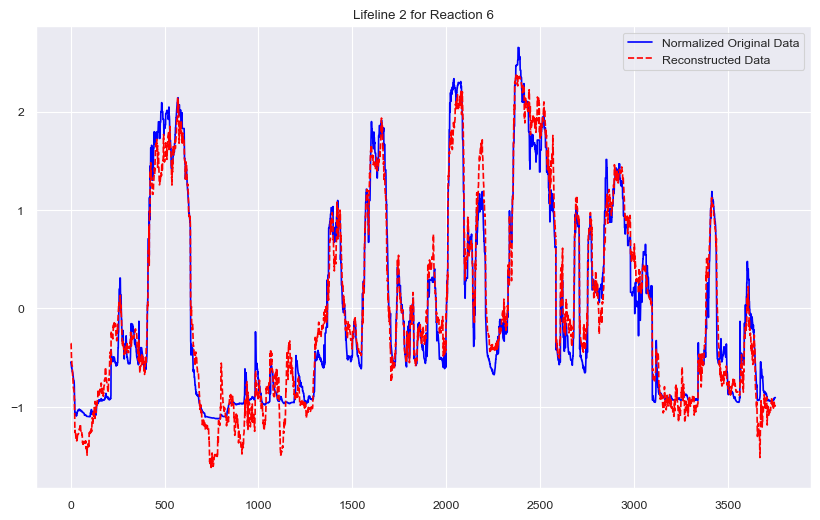

In [9]:
import matplotlib.pyplot as plt

original_data_reshaped = original_data.reshape(original_data.shape[0], original_data.shape[1], 1)
reconstructed_data_2d = autoencoder.predict(original_data_reshaped)

# Reshape reconstructed data back to the original 3D shape
reconstructed_data_3d = reconstructed_data_2d.reshape(data_3d.shape[0], data_3d.shape[1], data_3d.shape[2])

# Extract series for a specific lifeline and reaction
lifeline_index = 2
reaction_index = 6

# Normalized original series
normalized_original_series = data_3d[:, lifeline_index, reaction_index]

# Reconstructed series
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.legend()
plt.show()


In [11]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data_14lifelines.csv", index=False)


In [ ]:
# Save the entire model to a file
autoencoder.save('path_to_14lifeline_autoencoder.h5')  # The .h5 extension indicates a HDF5 file

In [1]:
# Step 1: Create the encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Step 2: Get the weights of the first layer of the encoder
# (assuming 'encoder' is the first layer of your encoder)
encoder_weights = encoder_model.layers[1].get_weights()[0]

# Step 3: Analyze the weights
# You can use various methods to analyze these weights.
# For example, you can look at the absolute values to see which original features
# contribute most to each latent feature.

# Printing the shape of the weights for understanding
print("Shape of encoder weights:", encoder_weights.shape)

# If you want to visualize the weights for each latent feature
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a list of names for your original features
feature_names = ['Feature1', 'Feature2', 'Feature3', ...]  # Replace with your actual feature names

for i in range(latent_units):  # Loop over each latent feature
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=encoder_weights[:, i])
    plt.title(f'Feature Contributions to Latent Feature {i}')
    plt.xticks(rotation=45)
    plt.show()


NameError: name 'Model' is not defined